# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1oJ90ueIz-moe9pjXtNYpz0dIz08UBRzP?usp=sharing

In [34]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import time
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [211]:
print("The maximum value at each desired column: \n")
print(subdf.max(), '\n')
print('The minimum value at each desired column: \n')
print(subdf.min(), '\n')
print('The average value at each desired column: \n')
print(subdf.mean())

The maximum value at each desired column: 

age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64 

The minimum value at each desired column: 

age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64 

The average value at each desired column: 

age          38.581647
yredu        10.080679
capgain    1077.648844
caploss      87.303830
workhr       40.437456
dtype: float64


In [9]:
df[["age", "yredu", "capgain", "caploss", "workhr"]] = (subdf - subdf.min())/(subdf.max() - subdf.min())
print('This is the normalized dataframe: \n')
df[:3]

This is the normalized dataframe: 



,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [10]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [11]:
total_people = df["sex"].size
male_num = sum(df["sex"] == " Male")
female_num = sum(df["sex"] == " Female")

print("The percentage of male in our dataset is: ",
      male_num/total_people*100 ,'%.')
print("The percentage of female in our dataset is: ",
      female_num/total_people*100 ,'%.')

The percentage of male in our dataset is:  66.92054912318419 %.
The percentage of female in our dataset is:  33.07945087681583 %.


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [12]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [13]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [14]:
print(df_with_missing.shape[0], "records contains missing features.")
print(df_with_missing.shape[0]/df.shape[0]*100, "% of records were removed.")

1843 records contains missing features.
5.660145572924664 % of records were removed.


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [15]:
work_types = set(df_not_missing["work"])
print("All the possible values of \"work\" are: ")

for type in work_types:
  print(type)

All the possible values of "work" are: 
 Federal-gov
 Local-gov
 Without-pay
 Private
 State-gov
 Self-emp-inc
 Self-emp-not-inc


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [16]:
data = pd.get_dummies(df_not_missing)

In [17]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [18]:
print("There are", data.shape[1],"columns in data.")

There are 57 columns in data.


In [19]:
#This number comes from the sum of the number of
#all possible values of the categorial features
#and the number of continuous features.

number = len(work_types) + len(set(df_not_missing["marriage"])) + len(set(df_not_missing["occupation"])) + len(set(df_not_missing["edu"])) + len(set(df_not_missing["relationship"])) + len(set(df_not_missing["sex"])) + len(contcols)
print(number)

57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [20]:
datanp = data.values.astype(np.float32)

In [21]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

In [22]:
cat_index

{'work': 5,
 'marriage': 12,
 'occupation': 19,
 'edu': 33,
 'relationship': 49,
 'sex': 55}

In [23]:
cat_values

{'work': ['Federal-gov',
  'Local-gov',
  'Private',
  'Self-emp-inc',
  'Self-emp-not-inc',
  'State-gov',
  'Without-pay'],
 'marriage': ['Divorced',
  'Married-AF-spouse',
  'Married-civ-spouse',
  'Married-spouse-absent',
  'Never-married',
  'Separated',
  'Widowed'],
 'occupation': ['Adm-clerical',
  'Armed-Forces',
  'Craft-repair',
  'Exec-managerial',
  'Farming-fishing',
  'Handlers-cleaners',
  'Machine-op-inspct',
  'Other-service',
  'Priv-house-serv',
  'Prof-specialty',
  'Protective-serv',
  'Sales',
  'Tech-support',
  'Transport-moving'],
 'edu': ['10th',
  '11th',
  '12th',
  '1st-4th',
  '5th-6th',
  '7th-8th',
  '9th',
  'Assoc-acdm',
  'Assoc-voc',
  'Bachelors',
  'Doctorate',
  'HS-grad',
  'Masters',
  'Preschool',
  'Prof-school',
  'Some-college'],
 'relationship': ['Husband',
  'Not-in-family',
  'Other-relative',
  'Own-child',
  'Unmarried',
  'Wife'],
 'sex': ['Female', 'Male']}

In [24]:
def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    max_index = np.argmax(onehot)
    return cat_values[feature][max_index]

In [25]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

In [26]:
get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")

'Private'

In [27]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [28]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)

#indicate split points
split_1 = int(len(datanp) * 0.7)
split_2 = int(len(datanp) * 0.85)

train_data= datanp[:split_1]
val_data = datanp[split_1:split_2]
test_data = datanp[split_2:]

print("There are ", len(train_data), "items in training set.")
print("There are ", len(val_data), "items in validation set.")
print("There are ", len(test_data), "items in test set.")

There are  21502 items in training set.
There are  4608 items in validation set.
There are  4608 items in test set.


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [185]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 40), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(40,20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20,40),
            nn.ReLU(),
            nn.Linear(40, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [30]:
#Sigmoid function forces the output to be
#in the range of [0,1] since the values in the dataframe
#data is normalized to the range of [0,1]

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [178]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                  epoch)
    return path

def train(model, train_data, valid_data, batch_size = 64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    start_time = time.time()
    n = 0
    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        total_val_loss = 0.0
        i = 0

        for data in val_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            total_val_loss += loss.item()
            i += 1

        val_loss = float(total_val_loss)/(i + 1)

        iters.append(n)
        train_losses.append(float(train_loss) / batch_size) # compute *average* loss
        val_losses.append(float(val_loss)/batch_size)
        n += 1
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        train_acc.append(get_accuracy(model, train_loader))  # compute training accuracy
        val_acc.append(get_accuracy(model, val_loader))    #compute validation accuracy
        print(("Epoch {}: Train accuracy: {} |" +
               "Validation accuracy: {} ").format(
                epoch +1,
                train_acc[epoch],
                val_acc[epoch]))

    print("Finish Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(1, num_epochs+1), train_acc, label="Train")
    plt.plot(range(1, num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [179]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1: Train accuracy: 0.41884475862710446 |Validation accuracy: 0.4173538773148148 
Epoch 2: Train accuracy: 0.45828295042321643 |Validation accuracy: 0.45793547453703703 
Epoch 3: Train accuracy: 0.4658558893746318 |Validation accuracy: 0.4641927083333333 
Epoch 4: Train accuracy: 0.5206259882801599 |Validation accuracy: 0.5186270254629629 
Epoch 5: Train accuracy: 0.5282454345332217 |Validation accuracy: 0.5290436921296297 
Epoch 6: Train accuracy: 0.5402675720088054 |Validation accuracy: 0.541015625 
Epoch 7: Train accuracy: 0.5467398381545903 |Validation accuracy: 0.5477068865740741 
Epoch 8: Train accuracy: 0.5544833038787089 |Validation accuracy: 0.5533492476851852 
Epoch 9: Train accuracy: 0.5595370973242799 |Validation accuracy: 0.5583405671296297 
Epoch 10: Train accuracy: 0.5636529935199827 |Validation accuracy: 0.5648148148148148 
Epoch 11: Train accuracy: 0.56824171394909 |Validation accuracy: 0.5689742476851852 
Epoch 12: Train accuracy: 0.5765355160760239 |Validation a

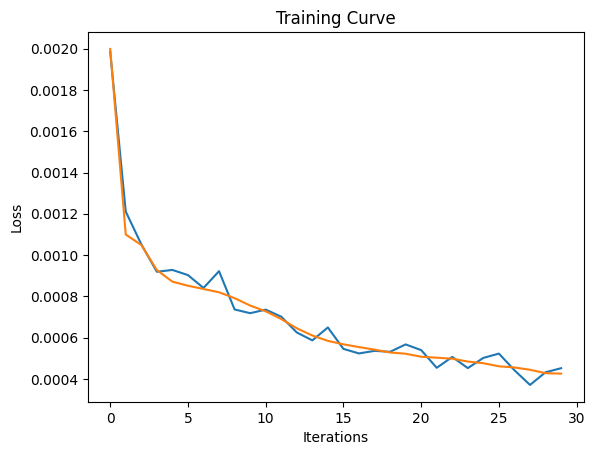

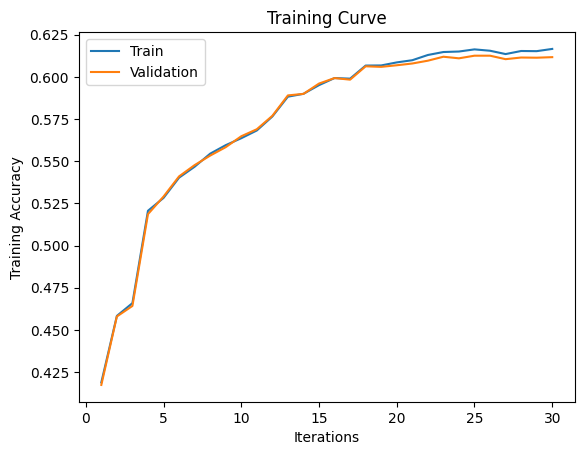

Final Training Accuracy: 0.6166093076613028
Final Validation Accuracy: 0.6117259837962963


In [186]:
AE = AutoEncoder()
train(AE, train_data, val_data, num_epochs= 30)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

In [183]:
def no_plot_train(model, train_data, valid_data, batch_size = 64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    start_time = time.time()
    n = 0
    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        total_val_loss = 0.0
        i = 0

        for data in val_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            total_val_loss += loss.item()
            i += 1

        val_loss = float(total_val_loss)/(i + 1)

        iters.append(n)
        train_losses.append(float(train_loss) / batch_size) # compute *average* loss
        val_losses.append(float(val_loss)/batch_size)
        n += 1
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        train_acc.append(get_accuracy(model, train_loader))  # compute training accuracy
        val_acc.append(get_accuracy(model, val_loader))    #compute validation accuracy

    print("Finish Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    print(("Final training accuracy: {}").format(train_acc[-1]))
    print(("Final validation accuracy: {}").format(val_acc[-1]))

In [187]:
model_1 = AutoEncoder()
no_plot_train(model_1, train_data, val_data, num_epochs = 50, learning_rate= 0.001)

#Hyperparameter set 1:

#batch_size = 64
#num_epochs = 50
#learning_rate = 0.001

#I kept the batch_size the same because I
#think the epoch is too short and the
#learning rate is too small.
#By increasing epochs and learning rate,
#the model will faster converge to its
#minimum loss.

Finish Training
Total time elapsed: 122.91 seconds
Final training accuracy: 0.6530322760673426
Final validation accuracy: 0.6509693287037037


In [188]:
model_2 = AutoEncoder()
no_plot_train(model_2, train_data, val_data,
              batch_size = 128, num_epochs = 50,
              learning_rate = 0.007)

#Hyperparameter set 2:

#batch_size = 128
#num_epochs = 50
#learning_rate = 0.007

#Based on the last training, I increases the batch_size
#because the dataset is very large, larger batch_size
#will help increase training efficiency.
#I also increase the learning_rate a bit more to 0.007
#to see if the model can converge more than the last
#training.

Finish Training
Total time elapsed: 122.28 seconds
Final training accuracy: 0.6938734381297864
Final validation accuracy: 0.6915147569444444


In [190]:
model_3 = AutoEncoder()
no_plot_train(model_3, train_data, val_data,
              batch_size = 128, num_epochs = 80,
              learning_rate = 0.007)

#Hyperparameter set 3:

#batch_size = 128
#num_epochs = 80
#learning_rate = 0.007

#Model_2 did outperform the model_1, so
#in model_3, I will keep the same batch_size and
#learning_rate.
#I increase the epochs to 80 because the
#model's accuracy still seems to be increasing
#at the end of the last training.

Finish Training
Total time elapsed: 195.79 seconds
Final training accuracy: 0.6997798654388739
Final validation accuracy: 0.6951678240740741


Epoch 1: Train accuracy: 0.6103385731559855 |Validation accuracy: 0.6061197916666666 
Epoch 2: Train accuracy: 0.6171363904132949 |Validation accuracy: 0.6108940972222222 
Epoch 3: Train accuracy: 0.6183843363408055 |Validation accuracy: 0.6110387731481481 
Epoch 4: Train accuracy: 0.6173921805723499 |Validation accuracy: 0.6146918402777778 
Epoch 5: Train accuracy: 0.6297708740272223 |Validation accuracy: 0.6252893518518519 
Epoch 6: Train accuracy: 0.6441416302359471 |Validation accuracy: 0.6406611689814815 
Epoch 7: Train accuracy: 0.615725668930022 |Validation accuracy: 0.6130642361111112 
Epoch 8: Train accuracy: 0.6349719405946733 |Validation accuracy: 0.6308232060185185 
Epoch 9: Train accuracy: 0.6368244814435866 |Validation accuracy: 0.6331380208333334 
Epoch 10: Train accuracy: 0.6326930828140018 |Validation accuracy: 0.6264829282407407 
Epoch 11: Train accuracy: 0.6415527237776331 |Validation accuracy: 0.6399016203703703 
Epoch 12: Train accuracy: 0.6426378941493814 |Validat

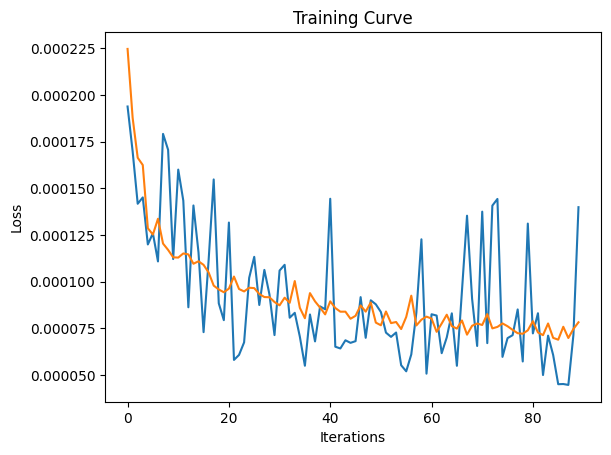

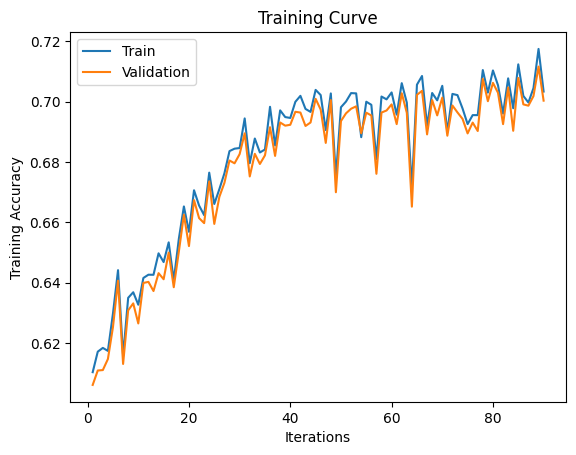

Final Training Accuracy: 0.7033221715809382
Final Validation Accuracy: 0.7003038194444444


In [194]:
model_4 = AutoEncoder()
train(model_4, train_data, val_data,
              batch_size = 128, num_epochs = 90,
              learning_rate = 0.0065)

#Hyperparameter set 4:

#batch_size = 128
#num_epochs = 90
#learning_rate = 0.007

#Model_3 performed better than model_2,
#so batch_size remain unchanged.
#But for the learning_rate, I will decrease
#it to 0.0065 to check if it can reach its
#minimum loss more slowly but accurately.
#The number of epochs is increased to 90 to
#see if the model's accuracy can still increase because
#in the last training, it seemed to be increasing in the
#end.

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [195]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
test_acc = get_accuracy(model_4, test_loader)
print(("Model_4's test accuracy is {} %.").format(test_acc*100))

Model_4's test accuracy is 69.76634837962963 %.


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [157]:
baseline_mod = {}
for col in df_not_missing.columns:
  # get the most common value for each column
  baseline_mod[col] = df_not_missing[col].value_counts().idxmax()

count = 0
for val in df_not_missing["marriage"]:
  if val == baseline_mod['marriage']:
    count += 1

baseline_acc = count/len(df_not_missing) * 100
print("The test accuracy of this baseline model on \"marriage\" is ", baseline_acc, "%")

The test accuracy of this baseline model on "marriage" is  46.67947131974738 %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
#Accuracy from part(a): 69.766%
#Accuracy from part(b): 46.679%

#My test accuracy from part(a) is much
#higher than the accuracy we see in part(b).
#This is because the model is not simply predicting
#the most common value for an input. Instead, it is
#learning to predict through the embeddings we construct
#that place importance on all features so that the model
#will have more comprehensive prediction.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [155]:
get_features(test_data[0])

#Yes, I think it is reasonable for a human
#to guess this person's education level based on
#other features. This person is a professional
#specialty, which requires professional
#knowledge and training on the specific area that
#he is working in, so it is reasonable to guess
#that he has a least completed a Bachelor's
#degree.

{'work': 'Private',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'edu': 'Bachelors',
 'relationship': 'Not-in-family',
 'sex': 'Male'}

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [209]:
edu_hidden = zero_out_feature(test_data[:1],"edu")[0]
prediction = model_4(torch.from_numpy(edu_hidden))
pred_val = get_feature(prediction.detach().numpy(),"edu")
print(pred_val)

#The predicted education level of this person
#is Masters, which is incorrect. The model
#overestimates the person's education level.

Masters


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [160]:
print("The baseline model's prediction of this person's education leverl is",
      baseline_mod["edu"], '.')

The baseline model's prediction of this person's education leverl is  HS-grad .
